# Autoencoders

In [27]:
from const import *
from IPython.display import display, Math, Image

## Structure of the Autoencoders

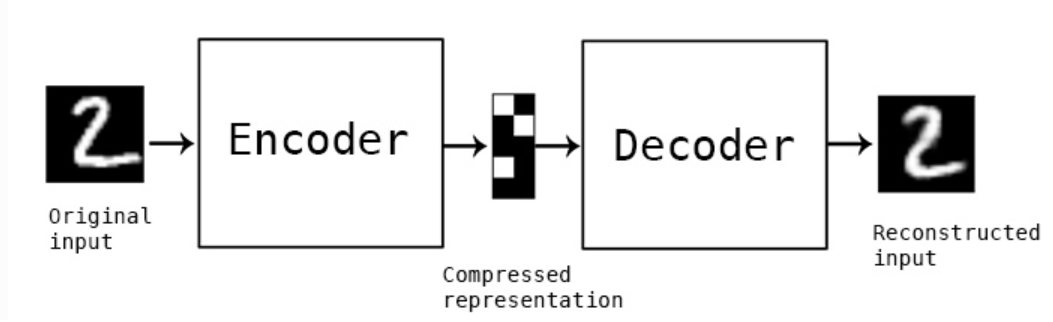

<IPython.core.display.Math object>

In [28]:
display(Image(filename=autoencoder_image, width=600, height=600))
display(Math(autoencoder_formulas))

### Autoencoders hyperparameters are:

- **number of layers**  for the *Encoder* and *Decoder* neural networks;
- **number of nodes** for each of these layers;
- **loss function** to use for the optimization process;
- **size of the latent space**, the smaller the size, the higher the compression and viceversa.

### Types of Autoencoders are:

- **Undercomplete Autoencoder**, where the size of the latent space is smaller than the size of the input;
- **Sparse Autoencoder**, where the number of nodes in the hidden layer is smaller than the number of nodes in the input layer;
- **Contractive Autoencoder**, where the loss function is augmented with a term that penalizes the derivative of the hidden layer with respect to the input;
- **Denoising Autoencoder**, where the input is corrupted by adding noise to it;
- **Convolutional Autoencoder**, where the encoder and decoder are convolutional neural networks;
- **Variational Autoencoder**, where the latent space is a probability distribution.

## Python Code

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # neural network
import torch.nn as nn # neural network
import torch.optim as optim # neural network
import matplotlib.pyplot as plt # plotting
from sklearn.preprocessing import StandardScaler, LabelEncoder # data preprocessing
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from sklearn.decomposition import PCA

## Weather Dataset Example 

In [30]:
df = pd.read_csv("datasets/weatherAUS.csv") # Load the dataset
df = df.drop(['Date', 'Location', 'WindDir9am', 'WindGustDir', 'WindDir3pm'], axis=1) # Drop the columns that are not needed
df = df.dropna(how = 'any') # Drop the rows with missing values
df.loc[df['RainToday'] == 'No', 'RainToday'] = 0 # Replace 'No' with 0
df.loc[df['RainToday'] == 'Yes', 'RainToday'] = 1 # Replace 'Yes' with 1
df.head(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,No
6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,No
6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,No
6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,No
6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,No


### Preprocessing

In [31]:
X, Y = df.drop('RainTomorrow', axis=1, inplace=False), df[['RainTomorrow']] # Split the dataset into features and labels

# Standardizing the features
scaler = StandardScaler() # mean of 0 and standard deviation of 1
X_scaled = scaler.fit_transform(X)

# Converting to PyTorch tensor
X_tensor = torch.FloatTensor(X_scaled)

# Converting string labels to numerical labels
label_encoder = LabelEncoder() 
Y_numerical = label_encoder.fit_transform(Y.values.ravel()) # Y.values.ravel() converts the 2D array to 1D array

### Autoencoder Model Definition 

In [32]:
class Autoencoder(nn.Module): # inherits from nn.Module
   
   def __init__(self, input_size, encoding_dim):  
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential( # encoder definition
           nn.Linear(input_size, 16), # sequential NN with a linear-layer 
           nn.ReLU(), # ReLU activation function
           nn.Linear(16, encoding_dim), # another linear-layer
           nn.ReLU() # another ReLU 
       )
       self.decoder = nn.Sequential( # decoder definition
           nn.Linear(encoding_dim, 16), 
           nn.ReLU(), 
           nn.Linear(16, input_size),
           nn.Sigmoid() # uses a sigmoid activation function because the input is standardized between 0 and 1
       )

   def forward(self, x): # ecoding and decoding the input
       x = self.encoder(x) 
       x = self.decoder(x)
       return x 

### Hyperparameters Tuning

In [33]:
torch.manual_seed(42) # seed for reproducibility

input_size = X.shape[1]  # Number of input features
encoding_dim = 3  # Desired number of output dimensions

model = Autoencoder(input_size, encoding_dim)

### Training

In [34]:
# Loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.003) # Adam optimizer

num_epochs = 20
for epoch in range(num_epochs):
   
   # Forward pass
   outputs = model(X_tensor) # outputs are the decoded inputs
   loss = criterion(outputs, X_tensor) # loss is the difference between the decoded inputs and the original inputs

   # Backward pass and optimization
   optimizer.zero_grad() # set the gradients to zero
   loss.backward() # backpropagation
   optimizer.step() # update the weights

   # Loss for each epoch
   print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Encoding the data using the trained autoencoder
encoded_data = model.encoder(X_tensor).detach().numpy()
decoded_data = model.decoder(torch.FloatTensor(encoded_data)).detach().numpy()

Epoch [1/20], Loss: 1.2443
Epoch [2/20], Loss: 1.2410
Epoch [3/20], Loss: 1.2376
Epoch [4/20], Loss: 1.2342
Epoch [5/20], Loss: 1.2307
Epoch [6/20], Loss: 1.2271
Epoch [7/20], Loss: 1.2234
Epoch [8/20], Loss: 1.2196
Epoch [9/20], Loss: 1.2156
Epoch [10/20], Loss: 1.2114
Epoch [11/20], Loss: 1.2070
Epoch [12/20], Loss: 1.2023
Epoch [13/20], Loss: 1.1974
Epoch [14/20], Loss: 1.1923
Epoch [15/20], Loss: 1.1868
Epoch [16/20], Loss: 1.1811
Epoch [17/20], Loss: 1.1751
Epoch [18/20], Loss: 1.1688
Epoch [19/20], Loss: 1.1622
Epoch [20/20], Loss: 1.1554


### Plotting on the latent space (3 dimensions)

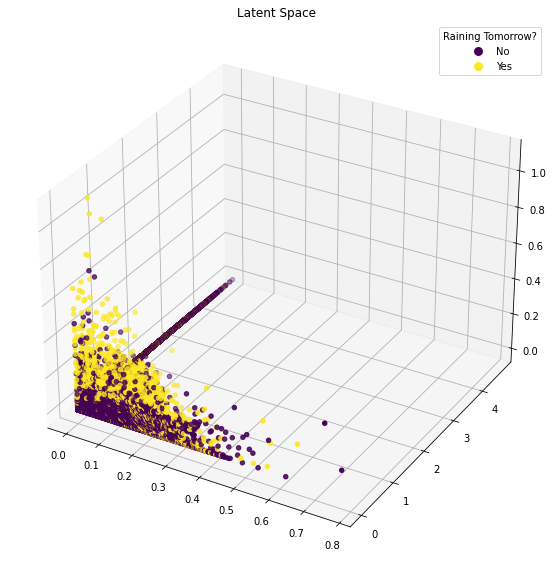

In [35]:
fig = plt.figure(figsize=(8, 8)) # Create a new figure
ax = fig.add_subplot(111, projection='3d') # Add a 3D subplot to the figure

# Scatter plot of the encoded data
scatter = ax.scatter(
                        encoded_data[:, 0], # x-axis 
                        encoded_data[:, 1], # y-axis
                        encoded_data[:, 2], # z-axis
                        c=Y_numerical, # color based on the labels
                        cmap='viridis' # color map
                    )

# Mapping numerical labels back to original string labels for the legend
labels = label_encoder.inverse_transform(np.unique(Y_numerical))

# Dictionary to store the mapping
legend_labels = {num: label for num, label in zip(np.unique(Y_numerical), labels)}

# Creating a custom legend with original string labels
handles = [
            plt.Line2D([0], # Create a line for each unique label  
            [0], # with a marker
            marker='o', # The marker is a circle
            color='w', # The color of the marker is white
            markerfacecolor=scatter.to_rgba(num), # The fill color of the marker corresponds to the label
            markersize=10, 
            label=legend_labels[num]) for num in np.unique(Y_numerical) # Create a marker for each unique label
        ]

ax.legend(handles=handles, title="Raining Tomorrow?")

ax.set_title('Latent Space')

plt.tight_layout() # Adjust the plot to ensure everything fits without overlapping
#plt.savefig('images\Rain_Prediction_Autoencoder.png')

plt.show()

### Plotting original and recostructed data over 2 dimensions 

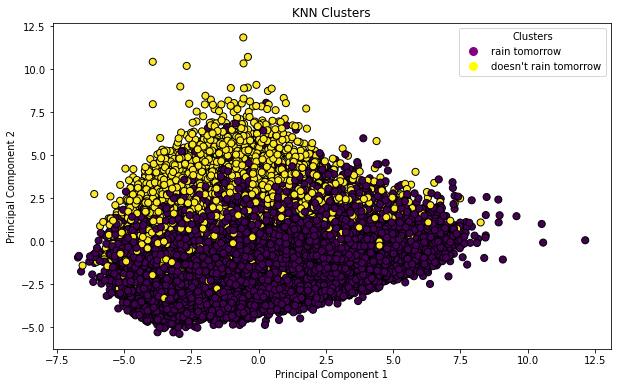

In [36]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(
                X_pca[:, 0], # x-axis 
                X_pca[:, 1], # y-axis 
                c=Y_numerical, # color based on the labels 
                cmap='viridis', # color map 
                marker='o', # marker style 
                edgecolor='black', # edge color 
                s=50 # marker size
            )

plt.title('KNN Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a custom legend
handles = [

    plt.Line2D(
                [0], 
                [0], 
                marker='o', 
                color='w', 
                markerfacecolor='purple', 
                markersize=10, 
                label='rain tomorrow'),

    plt.Line2D(
                [0], 
                [0], 
                marker='o', 
                color='w', 
                markerfacecolor='yellow', 
                markersize=10, 
                label='doesn\'t rain tomorrow')
]

plt.legend(handles=handles, title="Clusters")

plt.show()

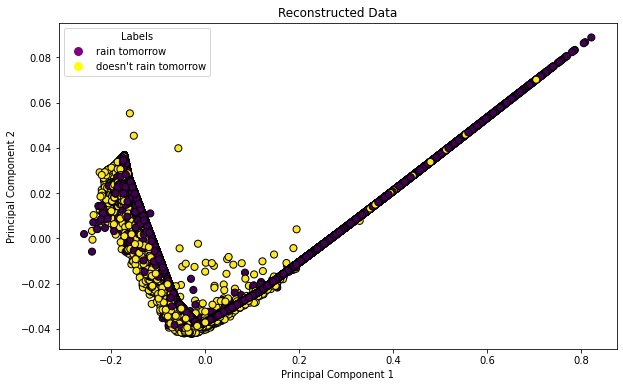

In [37]:
reconstructed_pca = PCA(n_components=2)
X_reconstructed_pca = reconstructed_pca.fit_transform(decoded_data)

# Plot the reconstructed data
plt.figure(figsize=(10, 6))
plt.scatter(
                X_reconstructed_pca[:, 0], # x-axis 
                X_reconstructed_pca[:, 1], # y-axis 
                c=Y_numerical, # color based on the labels 
                cmap='viridis', # color map 
                marker='o', # marker style 
                edgecolor='black', # edge color 
                s=50 # marker size
            )

plt.title('Reconstructed Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a custom legend
handles = [
    plt.Line2D(
                [0], 
                [0], 
                marker='o', 
                color='w', 
                markerfacecolor='purple', 
                markersize=10, 
                label='rain tomorrow'),

    plt.Line2D(
                [0], 
                [0], 
                marker='o', 
                color='w', 
                markerfacecolor='yellow', 
                markersize=10, 
                label='doesn\'t rain tomorrow')
]

plt.legend(handles=handles, title="Labels")

plt.show()